# Выделение групп пользователей на основе поведения для приложения "Ненужные вещи"

Цель исследования: определить группы пользователей различающихся по retention rate и конверсии. Проверить гипотезы

Описание данных:

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:
`event.time` — время совершения
`event.name` — название события
`user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
`userId` — идентификатор пользователя
`source` — источник, с которого пользователь установил приложение

Расшифровки событий:
`advert_open` — открытие карточки объявления
`photos_show` — просмотр фотографий в объявлении
`tips_show` — пользователь увидел рекомендованные объявления
`tips_click` — пользователь кликнул по рекомендованному объявлению
`contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
`contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
`map` — пользователь открыл карту размещенных объявлений
`search_1` — `search_7` — разные события, связанные с поиском по сайту
`favorites_add` — добавление объявления в избранное

In [18]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from scipy import stats as st
from statsmodels. stats.weightstats import ztest as ztest
import math as mth
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

In [19]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
display(mobile_sourсes)
display(mobile_dataset)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
...,...,...
4288,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex
4289,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex
4290,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex
4291,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


## Предобработка данных

### Работа с пропусками

Посмотрим пропуски в датасете mobile_sourсes. Для этого запросим информацию по датасету. Видим что пропуска отсутствуют.

In [20]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Посмотрим пропуски в датасете mobile_dataset. Для этого запросим информацию по датасету. Видим что пропуска отсутствуют.

In [21]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Запросив уникальные значения в столбце event.name датафрейма mobile_dataset мы видим что есть события 'contacts_show' и 'show_contacts'. Вероятнее всего это одно и то же событие названное немного по разному, потому объеденим их.

In [22]:
display(mobile_dataset['event.name'].unique())
mobile_dataset= mobile_dataset.replace({'event.name' : { 'contacts_show' : 'show_contacts'}})
display(mobile_dataset['event.name'].unique())

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

### Приведение в соответствие типов данных

Запросив информацию по датасету mobile_sourсes мы увидили что типы данных соответствуют. Того же нельзя сказать о датасете mobile_dataset, тут мы видим что необходимо изменить тип данных в столбце event.time на datetime.

In [23]:
mobile_dataset['event.time']=pd.to_datetime(mobile_dataset['event.time'])
display(mobile_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

### Работа с дубликатами

В датасете mobile_sourсes явных дубликатов не обнаружено. Так же мы не обнаружили в датафрейми повторяющихся id.

In [24]:
display(mobile_sourсes.duplicated().sum())
display(mobile_sourсes.info())
display(mobile_sourсes['userId'].nunique())

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

4293

В датасете mobile_dataset явных дубликатов не обнаружено.

In [25]:
display(mobile_dataset.duplicated().sum())
mobile_dataset.info()

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Проверка корректности наименований колонок и их переименование

Посмотрев информацию по датафрейму mobile_sourсes видим что стоит скорректировать название столбца userId. Необходимо убрать заглавную букву и отделить Id нижним подчеркиванием.

In [26]:
mobile_sourсes.info()
mobile_sourсes=mobile_sourсes.rename(columns={'userId':'user_id'})
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


В датафрейме mobile_dataset все названия столбцов нуждаются в корректировки. Стоит заменить точку на нижнее подчеркивание.

In [27]:
mobile_dataset.info()
mobile_dataset=mobile_dataset.rename(columns={'event.time':'event_time','event.name':'event_name','user.id':'user_id'})
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Вывод: Мы провели предварительную обработку данных. Для начала мы проверили данные на пропуска. Пропусков в датафреймах не обнаружено. Затем мы привели типы данных в соответствие. Тип данных в столбце event.time мы поменяли с object на datetime. Так же датафреймы были проверены на дубликаты. Дубликатов в датафреймах нет. И последнее, мы привели название столбцов в датафрепймах к общему виду. Убрали заглавные буквы, заменили точки на нижнее подчеркивание.

## Исследовальский Анализ данных:

Для начала объеденим два датасета по столбцу user_id

In [28]:
result_raw = mobile_dataset.merge(
    mobile_sourсes, on='user_id', how='left'
)

result_raw

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google


### Retention Rate

Создаем профиль с первой датой посещения пользователя и каналом скачивания приложения.

In [29]:
def get_profiles(result_raw):

    profiles = (
        result_raw.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first','source':'first'})
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()  
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    return profiles
profiles=get_profiles(result_raw)
profiles

,user_id,first_ts,source,dt,month
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-01
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19,2019-10-01
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18,2019-10-01
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25,2019-10-01
...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,yandex,2019-10-13,2019-10-01
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,yandex,2019-10-07,2019-10-01
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,google,2019-10-23,2019-10-01
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33.867145,yandex,2019-10-21,2019-10-01


Теперь можно посмотреть сколько каждый канал дал нам пользователей. Видим что самым популярным каналом оказался Yandex, таких пользователей 1934. Далее идут другие каналы, через них приложение было скачано 1230 раз. Через Google приложение скачали 1129 раз.

In [30]:
a=profiles.groupby('source').agg({'user_id': 'nunique'}).sort_values('user_id',ascending=False )
a.reset_index(inplace= True )
display(a)

,source,user_id
0,yandex,1934
1,other,1230
2,google,1129


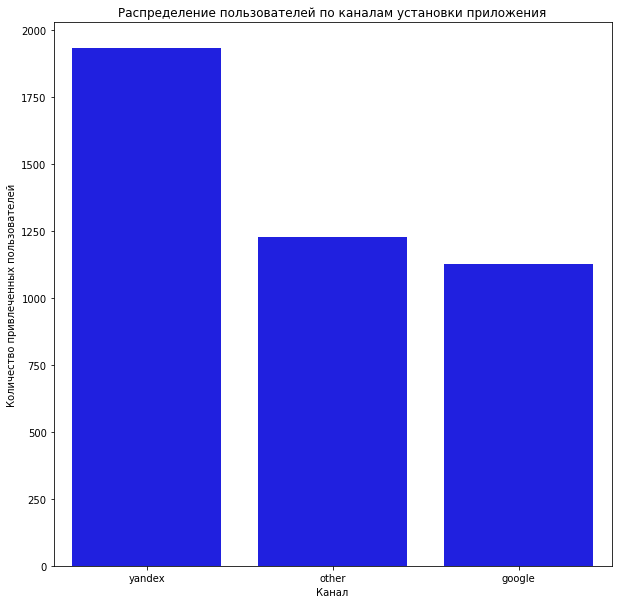

In [31]:
plt.figure(figsize=(10, 10))
sns.barplot(
    x='source', 
    y='user_id', 
    data=a,
    color='blue')
plt.title('Распределение пользователей по каналам установки приложения')
plt.ylabel('Количество привлеченных пользователей')
plt.xlabel('Канал')
plt.show()

Посмотрим динамику привлечения пользователей по дням в зависимости от канала. Yandex ожидаемо показывает лучшую динамику. Google  и иные каналы находятся знасчительно ниже и имеют частые пересечения линий. При этом все три канала имеют достаточно неравномерный график привлечения пользователей.

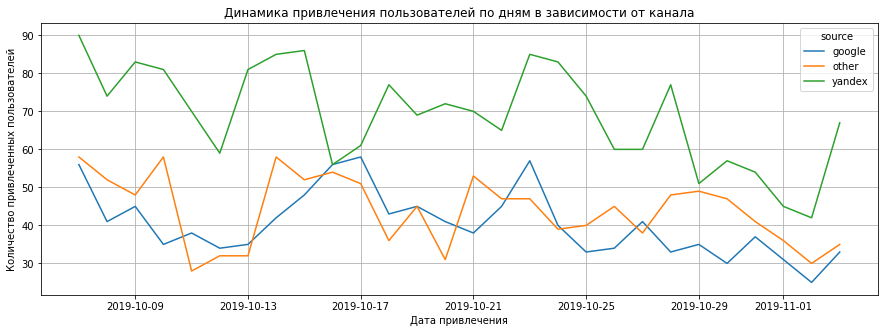

In [32]:
profiles.pivot_table(
    index='dt', 
    columns='source',
    values='user_id', 
    aggfunc='nunique' 
).plot(figsize=(15, 5), grid=True)
plt.title('Динамика привлечения пользователей по дням в зависимости от канала')
plt.ylabel('Количество привлеченных пользователей')
plt.xlabel('Дата привлечения')
plt.show()

Напишем функцию для расчета Retention Rate и Retention

In [33]:
def get_retention(
    profiles, result_raw, observation_date, horizon_days, ignore_horizon=True
):
    result_raw = result_raw.merge(
    profiles[['user_id','first_ts','dt','month']], on='user_id', how='left'
)
    result_raw['lifetime'] = (
    result_raw['event_time'] - result_raw['first_ts']
).dt.days
    result_grouped = result_raw.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)
    cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
    result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    result_grouped['cohort_size'] = cohort_sizes

    return result_raw, result_grouped



Расчитаем показатели

In [34]:
retention_raw, retention = get_retention(
    profiles, result_raw, datetime(2019, 11, 3).date(),10,ignore_horizon=True
)

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9
dt,,,,,,,,,,,
2019-10-07,204,1.0,0.122549,0.098039,0.107843,0.053922,0.039216,0.058824,0.078431,0.053922,0.049020
2019-10-08,167,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892,0.071856,0.059880,0.041916
2019-10-09,176,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818,0.073864,0.062500,0.034091
2019-10-10,174,1.0,0.091954,0.103448,0.080460,0.097701,0.080460,0.068966,0.051724,0.080460,0.034483
2019-10-11,136,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.073529,0.044118,0.014706,0.044118
2019-10-12,125,1.0,0.128000,0.160000,0.056000,0.064000,0.088000,0.080000,0.088000,0.080000,0.064000
2019-10-13,148,1.0,0.128378,0.067568,0.054054,0.067568,0.054054,0.054054,0.047297,0.047297,0.047297
2019-10-14,185,1.0,0.113514,0.102703,0.102703,0.081081,0.070270,0.054054,0.043243,0.075676,0.037838
2019-10-15,186,1.0,0.139785,0.091398,0.080645,0.053763,0.053763,0.080645,0.075269,0.064516,0.021505


Построим для наглядности тепловую карту. Видно что лучше всего показатели у первой и второй когорт. По остальным кагортам даже retention первого дня ниже.

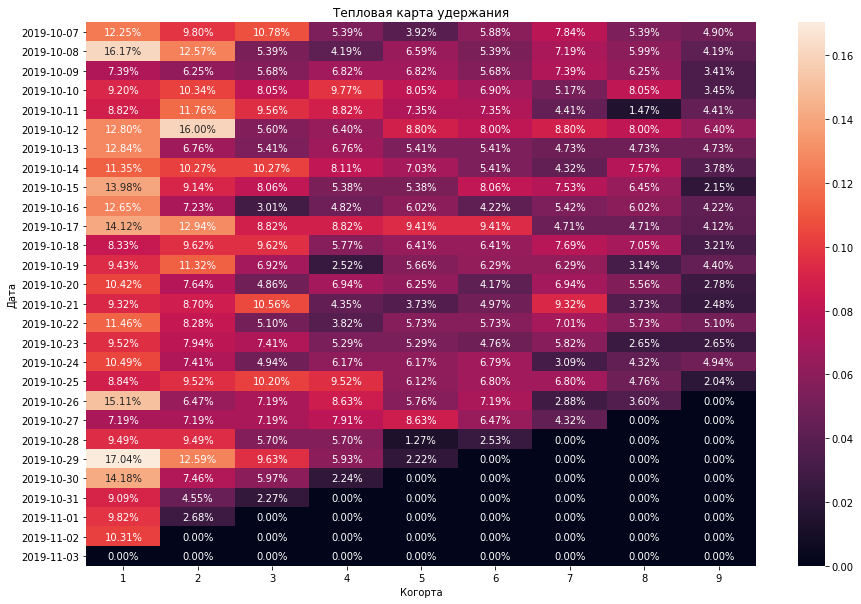

In [39]:
plt.figure(figsize=(15, 10)) 
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),
    annot=True,  
    fmt='.2%', 
)
plt.xlabel('Когорта')
plt.ylabel('Дата')
plt.title('Тепловая карта удержания') 
plt.show()

Кривая удержания пользователей. По ней мы опять же видим что лучше всего себя показывает первая когорта. 

In [40]:
report = retention.drop(columns = ['cohort_size']).T

report

dt,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,...,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.122549,0.161677,0.073864,0.091954,0.088235,0.128,0.128378,0.113514,0.139785,0.126506,...,0.088435,0.151079,0.071942,0.094937,0.170370,0.141791,0.090909,0.098214,0.103093,0.0
2,0.098039,0.125749,0.062500,0.103448,0.117647,0.160,0.067568,0.102703,0.091398,0.072289,...,0.095238,0.064748,0.071942,0.094937,0.125926,0.074627,0.045455,0.026786,0.000000,0.0
3,0.107843,0.053892,0.056818,0.080460,0.095588,0.056,0.054054,0.102703,0.080645,0.030120,...,0.102041,0.071942,0.071942,0.056962,0.096296,0.059701,0.022727,0.000000,0.000000,0.0
4,0.053922,0.041916,0.068182,0.097701,0.088235,0.064,0.067568,0.081081,0.053763,0.048193,...,0.095238,0.086331,0.079137,0.056962,0.059259,0.022388,0.000000,0.000000,0.000000,0.0
5,0.039216,0.065868,0.068182,0.080460,0.073529,0.088,0.054054,0.070270,0.053763,0.060241,...,0.061224,0.057554,0.086331,0.012658,0.022222,0.000000,0.000000,0.000000,0.000000,0.0
6,0.058824,0.053892,0.056818,0.068966,0.073529,0.080,0.054054,0.054054,0.080645,0.042169,...,0.068027,0.071942,0.064748,0.025316,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.078431,0.071856,0.073864,0.051724,0.044118,0.088,0.047297,0.043243,0.075269,0.054217,...,0.068027,0.028777,0.043165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.053922,0.059880,0.062500,0.080460,0.014706,0.080,0.047297,0.075676,0.064516,0.060241,...,0.047619,0.035971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.049020,0.041916,0.034091,0.034483,0.044118,0.064,0.047297,0.037838,0.021505,0.042169,...,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


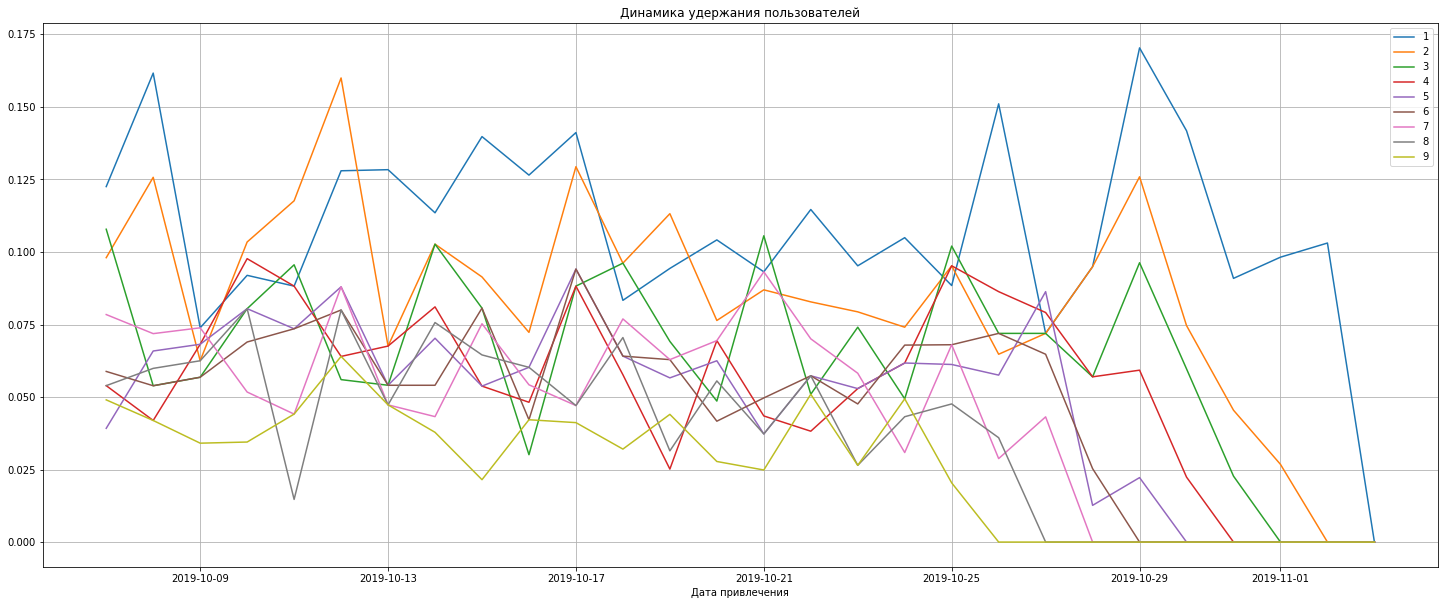

In [41]:
report = retention.drop(columns=['cohort_size', 0])

report.plot(grid=True, figsize=(25, 10))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

Вывод: Посчитав Retention rate мы выяснили что лучше всего себя показали когорты 1 и 2. Т.е. показатель удержания лучше по тем пользователям, что были привлечены в первой половине октября 2020 года.

### Время которое пользователи проводят в приложении

Мы выделили сессии. за время одной сессии мы взяли 40 минут. 40 минут были взяты из учета, что сессии более 40 минут для подобных приложений кажутся уже аномальными. Если же взять время сессий меньше, мы рискуем искусственно увеличить количество сессий.

Посмотрим сколько времени в среднем каждый пользователь проводит в приложении. Для этого мы выделили сессии и определили время начала и время окончания сессии. А затем посчитали сколько длится каждая сессия. В итоге получилось что в среднем пользователи проводили в приложении 33 минуты и 50 секунд. 

In [42]:
df=result_raw.sort_values(['user_id','event_time']) 
df['Timestamp'] = pd.to_datetime(df['event_time'])
g = (df.groupby('user_id')['Timestamp'].diff()> pd.Timedelta('40Min')).cumsum()
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
df0=df.groupby(['user_id','session_id']).agg({'event_time':['min','max']})
df0.columns = ['min', 'max']
df0.reset_index(inplace= True )
df0['time']=df0['max']-df0['min']
df1=df0.groupby('user_id').agg({'time':['sum']})
df1.columns = ['sum']
df1.reset_index(inplace= True )
display(df1['sum'].mean())
df1['sum'].max()

Timedelta('0 days 00:33:50.008090835')

Timedelta('1 days 07:30:10.761219')

In [43]:
df0['time'].describe()

count                        10029
mean     0 days 00:14:28.962482197
std      0 days 00:23:09.353049809
min                0 days 00:00:00
25%         0 days 00:00:28.887504
50%         0 days 00:06:00.572400
75%         0 days 00:19:08.100930
max         0 days 06:07:35.837396
Name: time, dtype: object

### Частота совершения события

 Посмотрим как часто каждый пользоватеь посещал приложение. Разброс в посещениях между пользователи очень большой, кто-то заходит всего 1 раз, а кто-то делает до 93 сессий за все время исследования. При этом средняя общая посещаемость составляет 2.33 сеанса за весь период 

In [44]:
sessions_per_user = df.groupby(['user_id']).agg(
    {'session_id': ['count','nunique']}
)
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user.reset_index(inplace= True )
sessions_per_user=sessions_per_user.drop(columns=['n_sessions'])
sessions_per_user=sessions_per_user.sort_values(by='n_users',ascending=False)
display(sessions_per_user)
display(sessions_per_user['n_users'].mean())
sessions_per_user['n_users'].unique()

,user_id,n_users
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,93
401,1580911b-65db-4f1a-be7e-1ca39becac30,51
3397,cb36854f-570a-41f4-baa8-36680b396370,44
1668,6383ff6a-04b8-4562-a98f-bb4f760d3c39,40
1875,70b57b3c-01b5-4635-b0c5-ed14b94e1359,36
...,...,...
2095,7e28b3ef-29d3-4b6e-b208-3d8ca25a88ed,1
2096,7e2a47b2-4493-4719-8f23-5a978589d839,1
350,12531b85-1350-47f6-9466-fe12922f9967,1
2098,7e2ecdc9-d832-467e-a6b0-be2dd4643c53,1


2.3361285814116

array([93, 51, 44, 40, 36, 35, 32, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21,
       20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,
        3,  2,  1])

Мы видим что больше половины пользователей совершили не больше одной сессии. При этом больше 62 сессий совершили всего 62 пользователя.

In [45]:
user_31=sessions_per_user.query('n_users<=1')
user_31['n_users'].count()

2379

In [46]:
user_62=sessions_per_user.query('1 < n_users <=62')
user_62['n_users'].count()

1913

In [47]:
user_93=sessions_per_user.query('62<n_users<=93')
user_93['n_users'].count()

1

Теперь посмотрим на посещаемость приложения в разрезе дней. Посещения колеблются от 226 сеансов в день до 450 сеансов. При этом средняя посещаемость сайта 360.17 сеансов в день.

In [48]:
df['dt'] = df['event_time'].dt.date
sessions_per_dt = df.groupby(['dt']).agg(
    {'session_id': ['count','nunique']}
)
sessions_per_dt.columns = ['n_sessions', 'n_users']
sessions_per_dt.reset_index(inplace= True )
sessions_per_dt=sessions_per_dt.drop(columns=['n_sessions'])
display(sessions_per_dt)
display(sessions_per_dt['n_users'].mean())
sessions_per_dt['n_users'].unique()

,dt,n_users
0,2019-10-07,238
1,2019-10-08,268
2,2019-10-09,276
3,2019-10-10,298
4,2019-10-11,268
5,2019-10-12,226
6,2019-10-13,280
7,2019-10-14,377
8,2019-10-15,387
9,2019-10-16,364


360.17857142857144

array([238, 268, 276, 298, 226, 280, 377, 387, 364, 404, 402, 340, 336,
       420, 401, 450, 418, 400, 373, 396, 449, 429, 430, 365, 306])

Построим гисторгамму по полученным данным. Видно что в начале месяца пользователи совершают меньше сессий в день, а к концу месяца этот показатель подрастает.

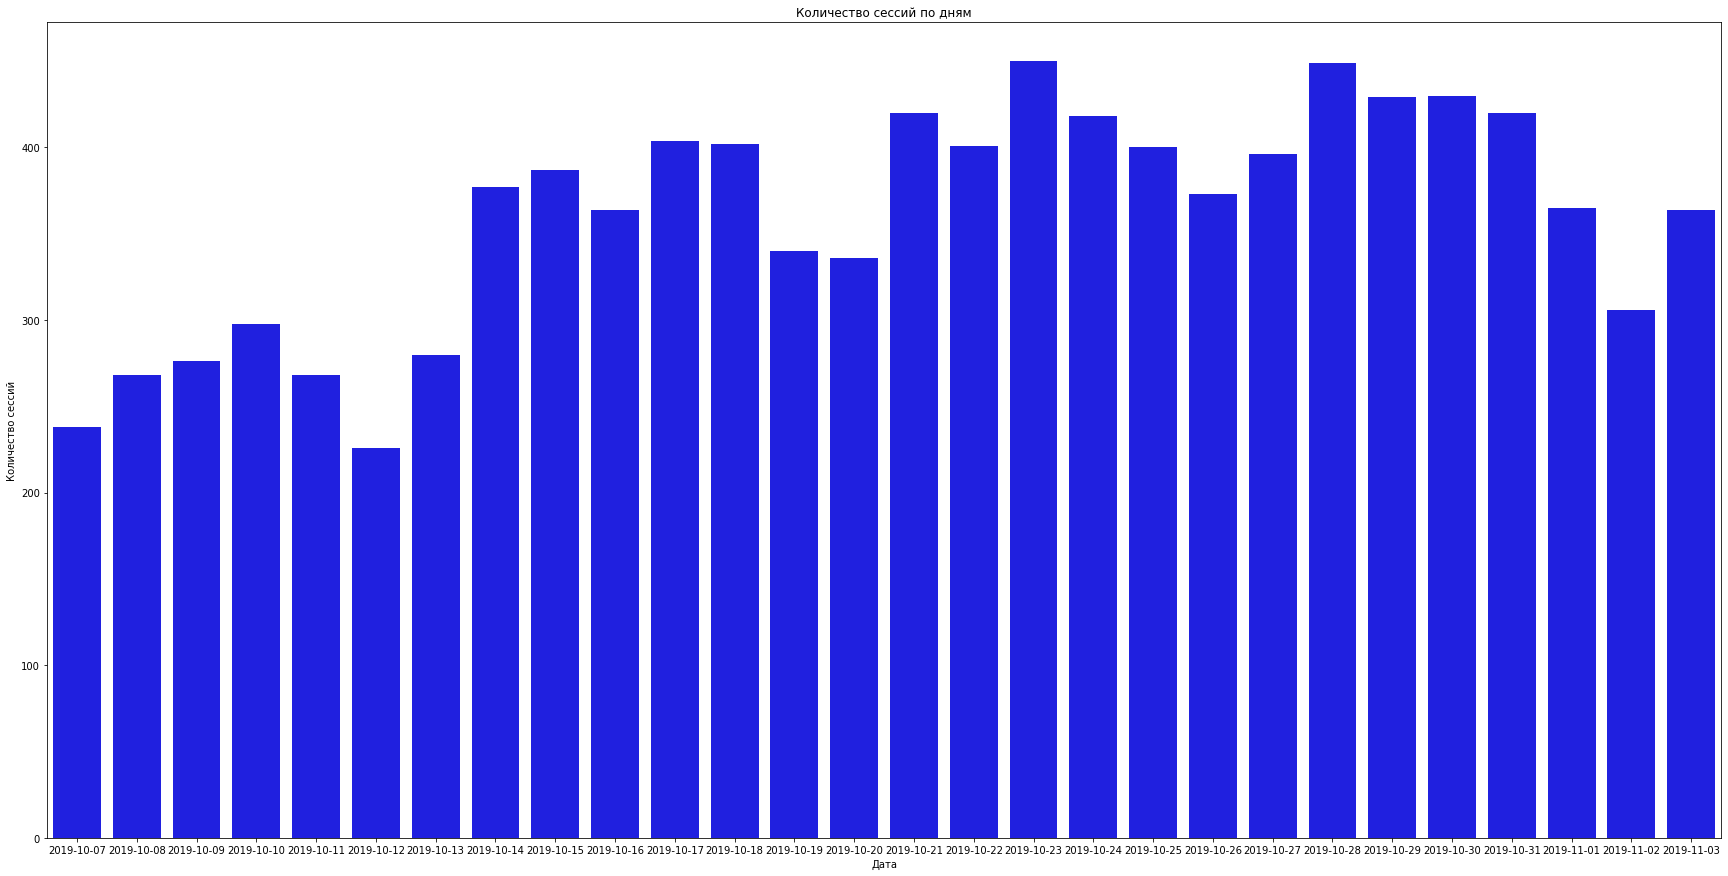

In [49]:
plt.figure(figsize=(30, 15))
sns.barplot(
    x='dt', 
    y='n_users', 
    data=sessions_per_dt,
    color='blue')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')
plt.title('Количество сессий по дням')
plt.show()

Вывод: Проведя ряд подсчетов мы выяснили что в среднем каждый пользователь сделал в среднем 2.33 сессии. При этом имеется сильный разброс между пользователями, встречаются как те кто зашел всего 1 раз, так и те кто делал до 93 сессий. При этом больше половины всех пользователей зашли в приложение не больше одного раза, 2379 пользователей. 1913 пользователей совершили не больше 62 сессий. И лишь один пользователь зашел в приложение больше 62 раз.

Что касается общего количества сессий в день, то тут средний показатель составляет 360.17. При этом колебания по дням составляют от 226 сеансов до 450 сеансов в день. Интересным наблюдением стало то, что к во второй половини. месяца количество сессий в день подрастает по сравнению с первой половиной месяца.



### Конверсию в целевое действие (show_contacts)

Подготовим данные для расчета конверсии. Посмотрим сколько уникальных пользователей совершали действия и сохраним эту цифру в переменную а.

In [50]:
a=result_raw['user_id'].nunique()
a

4293

Далее посмотрим сколько уникальных пользователей совершили целевое действияе. И сохраним эту цифру в переменной b.

In [51]:
purchases=result_raw.query('event_name=="show_contacts"')
b=purchases['user_id'].nunique()
b

981

Посчитаем конверсию. Мы выяснили что конверсия в целевое действие составляет 0.228

In [52]:
conv=b/a
conv

0.22851153039832284

Вывод: Посмотрели на профили пользователей. Выяснили что показатель удержание клиентов выше вспего у тех, кто установил приложение через yandex. Посчитав retention rate установили, что лучше всего показатели у первой когорты. По остальным кагортам retention ниже. Посчитав время сессий клиентов, получилось что в среднем пользователи проводили в приложении 33 минуты 50 секунд. При этом максимальное время достигало 1 день 7 часов 30 минут. Если говорить о частоте посещения приложения каждым пользователем, то вышло что в среднем этот показатель составляет 2,33 сессии за весь период. При этом имеется большой разброс между пользователями. Кто-то делает одну сессию за весь период, а есть те кто делает до 44 сессий. Посмотрев на общее количество посещений по дням, получили следующий результат.  Посещения колеблются от 226 сеансов в день до 450 сеансов. При этом средняя посещаемость сайта 360.17 сеансов в день. Конверсия в целевые действия составляет 0.228.



## Сегментация пользователей на основе действий на 3-4 группы:

Приведем данные датафрейма result_raw к нужному формату

In [53]:
result_raw= result_raw.merge(
    df1, on='user_id', how='left'
)
result_raw= result_raw.merge(
    sessions_per_user, on='user_id', how='left'
)
result_raw=result_raw.rename(columns={'sum':'total_time','n_sessions':'general_sessions','n_users':'count_session'})
result_raw=result_raw.drop('count_session',axis = 1)
result_raw

,event_time,event_name,user_id,source,total_time
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059
...,...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google,0 days 00:12:39.074868
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684


In [54]:
result_class=result_raw.drop('event_time',axis = 1)
result_class=result_class.drop('event_name',axis = 1)
my_label = preprocessing.LabelEncoder()  
result_class['user_id']= my_label.fit_transform(result_class['user_id'])    
result_class['source']= my_label.fit_transform(result_class['source'])
result_class['total_time']= my_label.fit_transform(result_class['total_time']) 
print(result_class )

       user_id  source  total_time
0           37       1        2265
1           37       1        2265
2         3475       2        4085
3           37       1        2265
4         3475       2        4085
...        ...     ...         ...
74192      740       0        4204
74193      740       0        4204
74194      602       0        1791
74195      740       0        4204
74196      740       0        4204

[74197 rows x 3 columns]


Проведем кластеризацию на 3 группы

In [55]:
scaler = StandardScaler()
scaler.fit(result_class)
x_sc = scaler.fit_transform(result_class)
x_sc

array([[-1.71441602, -0.22251081, -0.72795825],
       [-1.71441602, -0.22251081, -0.72795825],
       [ 1.04207484,  0.97029567,  0.87591324],
       ...,
       [-1.26141505, -1.41531729, -1.14566983],
       [-1.15077057, -1.41531729,  0.98078176],
       [-1.15077057, -1.41531729,  0.98078176]])

In [56]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(x_sc)
result_class['cluster'] =labels
display(result_class)

,user_id,source,total_time,cluster
0,37,1,2265,0
1,37,1,2265,0
2,3475,2,4085,2
3,37,1,2265,0
4,3475,2,4085,2
...,...,...,...,...
74192,740,0,4204,1
74193,740,0,4204,1
74194,602,0,1791,0
74195,740,0,4204,1


Добавим кластеры в основной датафрейм

In [57]:
result_raw['cluster']=result_class['cluster']
result_raw

,event_time,event_name,user_id,source,total_time,cluster
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
...,...,...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google,0 days 00:12:39.074868,0
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1


Поделим данные на датафреймы по кластерам

In [58]:
result_raw_0=result_raw.query('cluster==0')
result_raw_1=result_raw.query('cluster==1')
result_raw_2=result_raw.query('cluster==2')

In [59]:
result_raw.groupby('cluster')['user_id'].nunique()

cluster
0    2316
1    1048
2     929
Name: user_id, dtype: int64

Кластер 0 собрал пользователей проводящих в приложении в среднем около 9 минут 24 секунд. Установка приложения была осуществлена через разные каналы: yandex, google и other. 

In [60]:
display(result_raw_0)
display(result_raw_0['total_time'].mean())
display(result_raw_0['source'].unique())
display(result_raw_0['event_name'].unique())

,event_time,event_name,user_id,source,total_time,cluster
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0 days 00:18:42.485791,0
...,...,...,...,...,...,...
74184,2019-11-03 23:48:47.344430,tips_click,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex,0 days 00:05:30.536966,0
74187,2019-11-03 23:50:05.753036,tips_click,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex,0 days 00:05:30.536966,0
74188,2019-11-03 23:51:08.879296,tips_click,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex,0 days 00:05:30.536966,0
74189,2019-11-03 23:52:01.835490,tips_click,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex,0 days 00:05:30.536966,0


Timedelta('0 days 00:09:24.721722126')

array(['other', 'google', 'yandex'], dtype=object)

array(['advert_open', 'tips_show', 'map', 'search_4', 'search_5',
       'photos_show', 'search_1', 'show_contacts', 'search_3', 'search_6',
       'search_7', 'tips_click', 'contacts_call', 'search_2',
       'favorites_add'], dtype=object)

Кластер 1 собрал пользователей проводящих в приложении в среднем около 2 часов 43 минут 20 секунд. Установка приложения была осуществлена через такие каналы: google и other.

In [61]:
display(result_raw_1)
display(result_raw_1['total_time'].mean())
display(result_raw_1['source'].unique())
display(result_raw_1['event_name'].unique())

,event_time,event_name,user_id,source,total_time,cluster
37,2019-10-07 00:09:33.715659,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,google,0 days 00:40:48.496061,1
44,2019-10-07 00:11:48.977227,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,google,0 days 00:40:48.496061,1
49,2019-10-07 00:13:34.329171,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,google,0 days 00:40:48.496061,1
50,2019-10-07 00:13:45.388325,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,google,0 days 00:40:48.496061,1
57,2019-10-07 00:15:03.196647,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,google,0 days 00:40:48.496061,1
...,...,...,...,...,...,...
74191,2019-11-03 23:53:24.962860,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1


Timedelta('0 days 02:43:20.710852052')

array(['google', 'other'], dtype=object)

array(['tips_show', 'photos_show', 'tips_click', 'search_4', 'search_2',
       'search_5', 'map', 'advert_open', 'search_3', 'show_contacts',
       'contacts_call', 'favorites_add', 'search_1', 'search_6',
       'search_7'], dtype=object)

Кластер 2 собрал пользователей проводящих в приложении в среднем около 3 часов 7 минут 1 секунда. Установка приложения была осуществлена через канал yandex.

In [62]:
display(result_raw_2)
display(result_raw_2['total_time'].mean())
display(result_raw_2['source'].unique())
display(result_raw['event_name'].unique())

,event_time,event_name,user_id,source,total_time,cluster
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
11,2019-10-07 00:02:06.225301,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0 days 02:46:23.327059,2
...,...,...,...,...,...,...
74154,2019-11-03 23:33:56.847344,tips_show,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex,0 days 00:22:28.330156,2
74156,2019-11-03 23:37:32.236349,show_contacts,ec70be94-3ea7-4ac2-90fb-da1a044d7e30,yandex,0 days 03:25:08.322243,2
74158,2019-11-03 23:41:15.665105,tips_show,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex,0 days 00:22:28.330156,2
74172,2019-11-03 23:45:20.197902,tips_show,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex,0 days 00:22:28.330156,2


Timedelta('0 days 03:07:01.808519460')

array(['yandex'], dtype=object)

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

Вывод: мы получили 3 группы пользователей . Вот их краткие портреты:

0 кластер Каналы установки приложения: yandex, google,other. Среднее время проведенное пользователями в приложении 9 минут 24 секунды

1 кластер Каналы установки приложения: google, other. Среднее время проведенное пользователями в приложении 2 часа 43 минут 20 секунды

2 кластер Каналы установки приложения: yandex. Среднее время проведенное пользователями в приложении 3 часа 7 минут 1 секундф

In [63]:
result_raw.groupby('cluster')['user_id'].nunique()

cluster
0    2316
1    1048
2     929
Name: user_id, dtype: int64

### Retention Rate по кластерам

#### Retention Rate для кластера 0

In [64]:
profiles_0=get_profiles(result_raw_0)

In [65]:
retention_raw, retention = get_retention(
    profiles_0, result_raw_0, datetime(2019, 11, 3).date(),10,ignore_horizon=True
)

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9
dt,,,,,,,,,,,
2019-10-07,100,1.0,0.050000,0.060000,0.110000,0.010000,0.030000,0.040000,0.040000,0.010000,0.020000
2019-10-08,84,1.0,0.107143,0.035714,0.023810,0.011905,0.023810,0.011905,0.000000,0.011905,0.000000
2019-10-09,100,1.0,0.050000,0.050000,0.060000,0.060000,0.060000,0.040000,0.020000,0.030000,0.010000
2019-10-10,98,1.0,0.040816,0.040816,0.030612,0.020408,0.030612,0.010204,0.010204,0.040816,0.020408
2019-10-11,71,1.0,0.084507,0.028169,0.042254,0.028169,0.014085,0.000000,0.014085,0.014085,0.014085
2019-10-12,63,1.0,0.031746,0.111111,0.015873,0.047619,0.015873,0.000000,0.000000,0.047619,0.000000
2019-10-13,69,1.0,0.057971,0.028986,0.000000,0.014493,0.028986,0.014493,0.014493,0.028986,0.028986
2019-10-14,87,1.0,0.114943,0.057471,0.091954,0.045977,0.022989,0.034483,0.011494,0.080460,0.022989
2019-10-15,100,1.0,0.070000,0.060000,0.070000,0.010000,0.030000,0.040000,0.040000,0.040000,0.000000


Построим тепловую карту. Видим достаточно странное распределение,и retention rate достаточно нестабилен. Но все же 1 и 2 кагорда токазывают лучшие результаты.

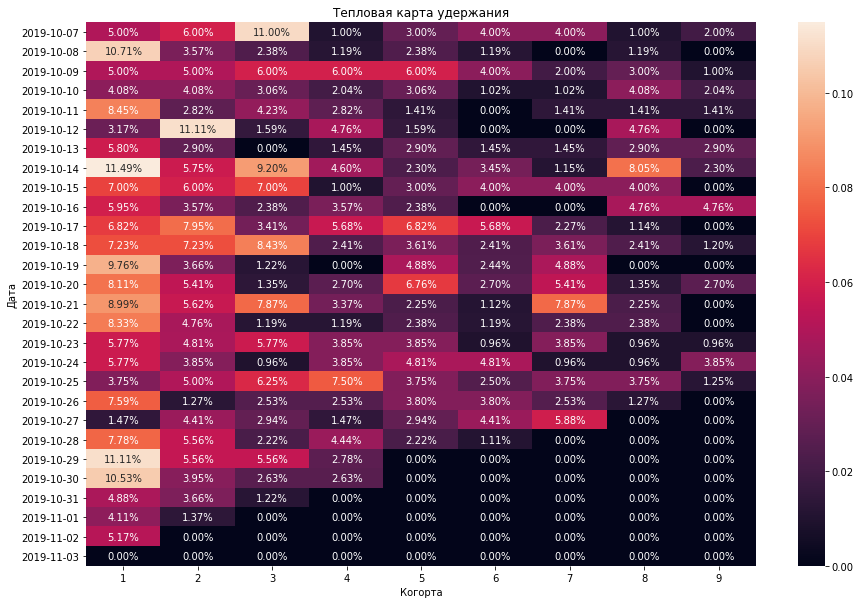

In [67]:
plt.figure(figsize=(15, 10)) 
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),
    annot=True,  
    fmt='.2%', 
)
plt.xlabel('Когорта')
plt.ylabel('Дата')
plt.title('Тепловая карта удержания') 
plt.show()

In [68]:
report = retention.drop(columns = ['cohort_size']).T

report

dt,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,...,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03
0,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,...,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.05,0.107143,0.05,0.040816,0.084507,0.031746,0.057971,0.114943,0.07,0.059524,...,0.0375,0.075949,0.014706,0.077778,0.111111,0.105263,0.048780,0.041096,0.051724,0.0
2,0.06,0.035714,0.05,0.040816,0.028169,0.111111,0.028986,0.057471,0.06,0.035714,...,0.0500,0.012658,0.044118,0.055556,0.055556,0.039474,0.036585,0.013699,0.000000,0.0
3,0.11,0.023810,0.06,0.030612,0.042254,0.015873,0.000000,0.091954,0.07,0.023810,...,0.0625,0.025316,0.029412,0.022222,0.055556,0.026316,0.012195,0.000000,0.000000,0.0
4,0.01,0.011905,0.06,0.020408,0.028169,0.047619,0.014493,0.045977,0.01,0.035714,...,0.0750,0.025316,0.014706,0.044444,0.027778,0.026316,0.000000,0.000000,0.000000,0.0
5,0.03,0.023810,0.06,0.030612,0.014085,0.015873,0.028986,0.022989,0.03,0.023810,...,0.0375,0.037975,0.029412,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.04,0.011905,0.04,0.010204,0.000000,0.000000,0.014493,0.034483,0.04,0.000000,...,0.0250,0.037975,0.044118,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.04,0.000000,0.02,0.010204,0.014085,0.000000,0.014493,0.011494,0.04,0.000000,...,0.0375,0.025316,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.01,0.011905,0.03,0.040816,0.014085,0.047619,0.028986,0.080460,0.04,0.047619,...,0.0375,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.02,0.000000,0.01,0.020408,0.014085,0.000000,0.028986,0.022989,0.00,0.047619,...,0.0125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Кривые удержания так же достаточно хаотичны, при. этом можно заметить что retenrion первой когорты все же имеет лучшие показатели.

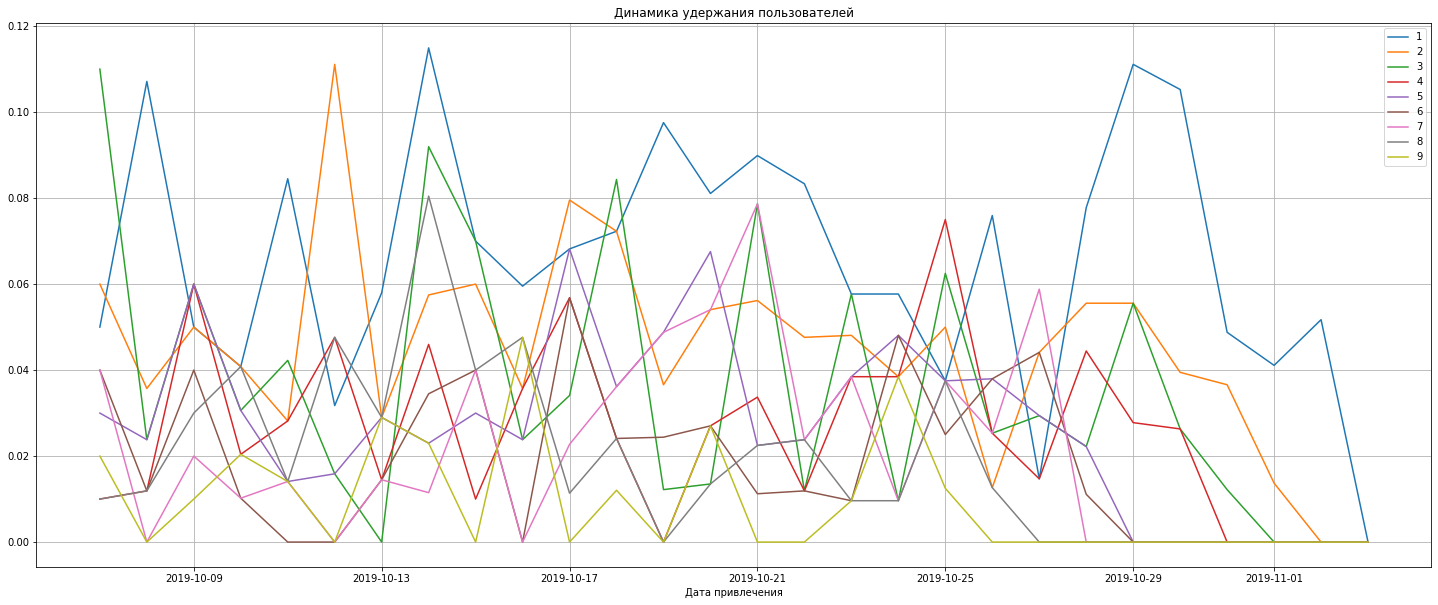

In [69]:
report = retention.drop(columns=['cohort_size', 0])

report.plot(grid=True, figsize=(25, 10))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

#### Retention Rate для кластера 1

In [70]:
profiles_1=get_profiles(result_raw_1)

In [71]:
retention_raw, retention = get_retention(
    profiles_1, result_raw_1, datetime(2019, 11, 3).date(),10,ignore_horizon=True
)

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9
dt,,,,,,,,,,,
2019-10-07,52,1.0,0.153846,0.115385,0.038462,0.076923,0.057692,0.057692,0.153846,0.096154,0.076923
2019-10-08,46,1.0,0.195652,0.239130,0.086957,0.086957,0.130435,0.108696,0.108696,0.108696,0.108696
2019-10-09,39,1.0,0.102564,0.051282,0.051282,0.153846,0.076923,0.128205,0.153846,0.102564,0.076923
2019-10-10,40,1.0,0.150000,0.175000,0.125000,0.125000,0.125000,0.125000,0.100000,0.150000,0.075000
2019-10-11,34,1.0,0.088235,0.117647,0.117647,0.058824,0.029412,0.058824,0.058824,0.000000,0.058824
2019-10-12,31,1.0,0.193548,0.258065,0.096774,0.096774,0.258065,0.193548,0.161290,0.161290,0.161290
2019-10-13,38,1.0,0.131579,0.052632,0.026316,0.052632,0.052632,0.105263,0.026316,0.026316,0.052632
2019-10-14,54,1.0,0.111111,0.129630,0.166667,0.148148,0.166667,0.074074,0.092593,0.074074,0.074074
2019-10-15,40,1.0,0.200000,0.075000,0.050000,0.100000,0.025000,0.075000,0.050000,0.050000,0.025000


Тепловая карта retention rate для кластера 1 имеет стабильную структуру. Лучшие показатели у когорты 1

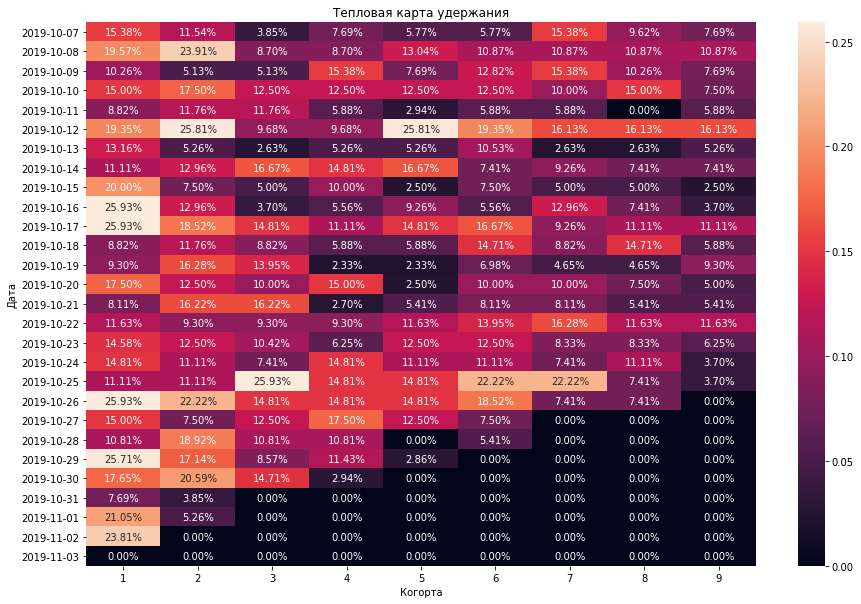

In [72]:
plt.figure(figsize=(15, 10)) 
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),
    annot=True,  
    fmt='.2%', 
)
plt.xlabel('Когорта')
plt.ylabel('Дата')
plt.title('Тепловая карта удержания') 
plt.show()

In [73]:
report = retention.drop(columns = ['cohort_size']).T

report

dt,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,...,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03
0,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,...,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.153846,0.195652,0.102564,0.150,0.088235,0.193548,0.131579,0.111111,0.200,0.259259,...,0.111111,0.259259,0.150,0.108108,0.257143,0.176471,0.076923,0.210526,0.238095,0.0
2,0.115385,0.239130,0.051282,0.175,0.117647,0.258065,0.052632,0.129630,0.075,0.129630,...,0.111111,0.222222,0.075,0.189189,0.171429,0.205882,0.038462,0.052632,0.000000,0.0
3,0.038462,0.086957,0.051282,0.125,0.117647,0.096774,0.026316,0.166667,0.050,0.037037,...,0.259259,0.148148,0.125,0.108108,0.085714,0.147059,0.000000,0.000000,0.000000,0.0
4,0.076923,0.086957,0.153846,0.125,0.058824,0.096774,0.052632,0.148148,0.100,0.055556,...,0.148148,0.148148,0.175,0.108108,0.114286,0.029412,0.000000,0.000000,0.000000,0.0
5,0.057692,0.130435,0.076923,0.125,0.029412,0.258065,0.052632,0.166667,0.025,0.092593,...,0.148148,0.148148,0.125,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.0
6,0.057692,0.108696,0.128205,0.125,0.058824,0.193548,0.105263,0.074074,0.075,0.055556,...,0.222222,0.185185,0.075,0.054054,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.153846,0.108696,0.153846,0.100,0.058824,0.161290,0.026316,0.092593,0.050,0.129630,...,0.222222,0.074074,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.096154,0.108696,0.102564,0.150,0.000000,0.161290,0.026316,0.074074,0.050,0.074074,...,0.074074,0.074074,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.076923,0.108696,0.076923,0.075,0.058824,0.161290,0.052632,0.074074,0.025,0.037037,...,0.037037,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Динамика удержания так же показывает превосходство кагорты 1.

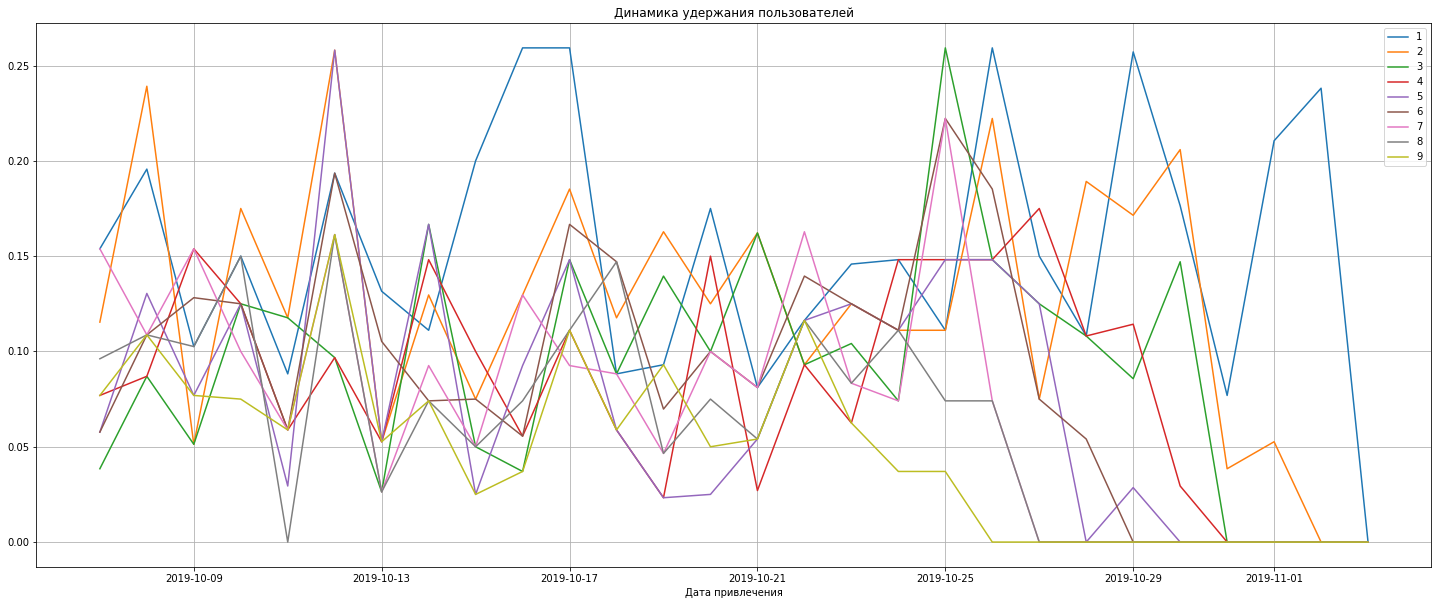

In [74]:
report = retention.drop(columns=['cohort_size', 0])

report.plot(grid=True, figsize=(25, 10))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

#### Retention Rate для кластера 2

In [75]:
profiles_2=get_profiles(result_raw_2)

In [76]:
retention_raw, retention = get_retention(
    profiles_2, result_raw_2, datetime(2019, 11, 3).date(),10,ignore_horizon=True
)

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9
dt,,,,,,,,,,,
2019-10-07,52,1.0,0.230769,0.153846,0.173077,0.115385,0.038462,0.096154,0.076923,0.096154,0.076923
2019-10-08,37,1.0,0.243243,0.189189,0.081081,0.054054,0.081081,0.081081,0.189189,0.108108,0.054054
2019-10-09,37,1.0,0.108108,0.108108,0.054054,0.000000,0.081081,0.027027,0.135135,0.108108,0.054054
2019-10-10,36,1.0,0.166667,0.194444,0.166667,0.277778,0.166667,0.166667,0.111111,0.111111,0.027778
2019-10-11,31,1.0,0.096774,0.322581,0.193548,0.258065,0.258065,0.258065,0.096774,0.032258,0.096774
2019-10-12,31,1.0,0.258065,0.161290,0.096774,0.064516,0.064516,0.129032,0.193548,0.064516,0.096774
2019-10-13,41,1.0,0.243902,0.146341,0.170732,0.170732,0.097561,0.073171,0.121951,0.097561,0.073171
2019-10-14,44,1.0,0.113636,0.159091,0.045455,0.068182,0.045455,0.068182,0.045455,0.068182,0.022727
2019-10-15,46,1.0,0.239130,0.173913,0.130435,0.108696,0.130435,0.173913,0.173913,0.130435,0.065217


И вновь по тепловой карте можно определить небольшое преимущество когорты 1

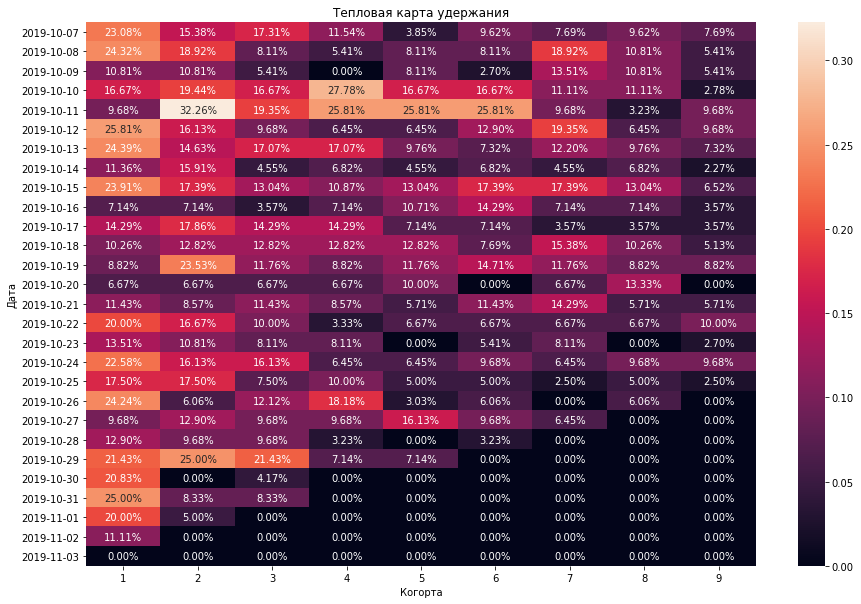

In [77]:
plt.figure(figsize=(15, 10)) 
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),
    annot=True,  
    fmt='.2%', 
)
plt.xlabel('Когорта')
plt.ylabel('Дата')
plt.title('Тепловая карта удержания') 
plt.show()

In [78]:
report = retention.drop(columns = ['cohort_size']).T

report

dt,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,...,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.0
1,0.230769,0.243243,0.108108,0.166667,0.096774,0.258065,0.243902,0.113636,0.239130,0.071429,...,0.175,0.242424,0.096774,0.129032,0.214286,0.208333,0.250000,0.20,0.111111,0.0
2,0.153846,0.189189,0.108108,0.194444,0.322581,0.161290,0.146341,0.159091,0.173913,0.071429,...,0.175,0.060606,0.129032,0.096774,0.250000,0.000000,0.083333,0.05,0.000000,0.0
3,0.173077,0.081081,0.054054,0.166667,0.193548,0.096774,0.170732,0.045455,0.130435,0.035714,...,0.075,0.121212,0.096774,0.096774,0.214286,0.041667,0.083333,0.00,0.000000,0.0
4,0.115385,0.054054,0.000000,0.277778,0.258065,0.064516,0.170732,0.068182,0.108696,0.071429,...,0.100,0.181818,0.096774,0.032258,0.071429,0.000000,0.000000,0.00,0.000000,0.0
5,0.038462,0.081081,0.081081,0.166667,0.258065,0.064516,0.097561,0.045455,0.130435,0.107143,...,0.050,0.030303,0.161290,0.000000,0.071429,0.000000,0.000000,0.00,0.000000,0.0
6,0.096154,0.081081,0.027027,0.166667,0.258065,0.129032,0.073171,0.068182,0.173913,0.142857,...,0.050,0.060606,0.096774,0.032258,0.000000,0.000000,0.000000,0.00,0.000000,0.0
7,0.076923,0.189189,0.135135,0.111111,0.096774,0.193548,0.121951,0.045455,0.173913,0.071429,...,0.025,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0
8,0.096154,0.108108,0.108108,0.111111,0.032258,0.064516,0.097561,0.068182,0.130435,0.071429,...,0.050,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0
9,0.076923,0.054054,0.054054,0.027778,0.096774,0.096774,0.073171,0.022727,0.065217,0.035714,...,0.025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0


Это же преимущество мы наблюдаем на графике удержания

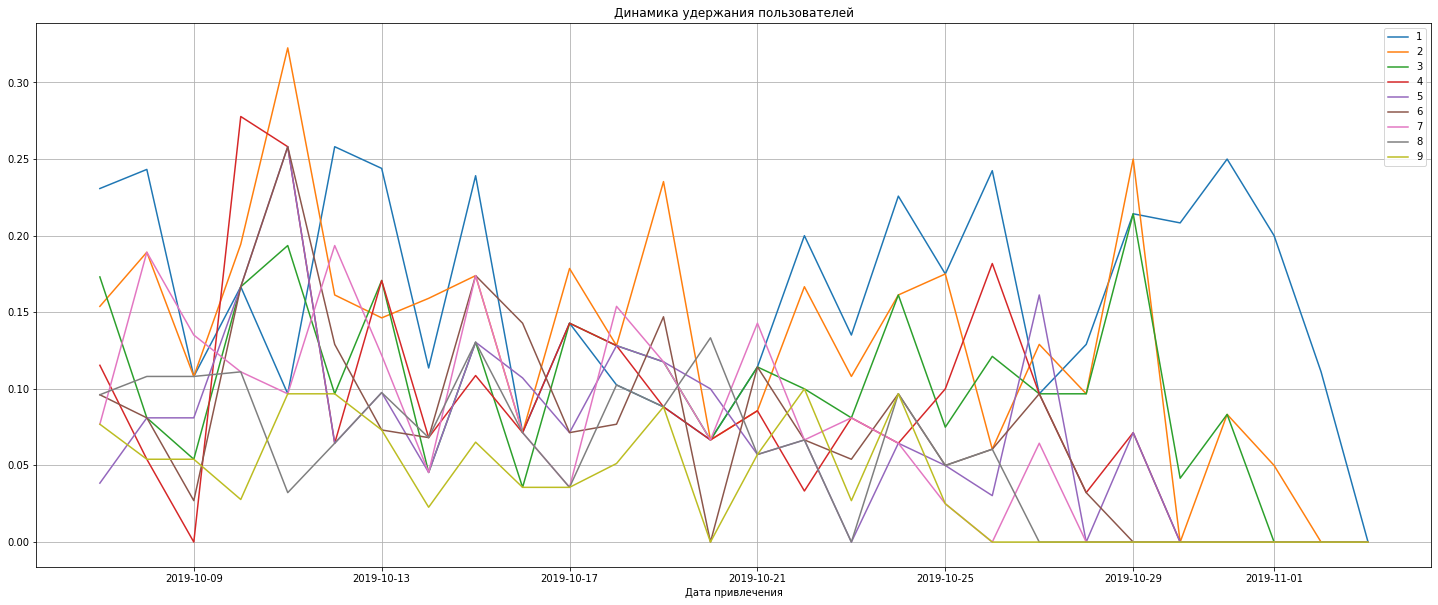

In [79]:
report = retention.drop(columns=['cohort_size', 0])

report.plot(grid=True, figsize=(25, 10))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

Вывод: посмотрев retention rate по каждому кластеру мы видим что во всех группах лучший показатель все так же держат 1 и 2 когорты.

### Конверсия по кластерам

#### Конверсия для кластера 0

Посмотрим конверсию для кластера 0. Конверсия для данного кластера 0.170

In [80]:
a_0=result_raw_0['user_id'].nunique()
a_0

2316

In [81]:
purchases_0=result_raw_0.query('event_name=="show_contacts"')
b_0=purchases_0['user_id'].nunique()
b_0

394

In [82]:
con_0=b_0/a_0
con_0

0.17012089810017272

#### Конверсия для кластера 1

Конверсия для кластера 1 составила 0.286

In [83]:
a_1=result_raw_1['user_id'].nunique()
a_1

1048

In [84]:
purchases_1=result_raw_1.query('event_name=="show_contacts"')
b_1=purchases_1['user_id'].nunique()
b_1

300

In [85]:
con_1=b_1/a_1
con_1

0.2862595419847328

#### Конверсия для кластера 2

Конверсия для кластера 2 составила 0.308

In [86]:
a_2=result_raw_2['user_id'].nunique()
a_2

929

In [87]:
purchases_2=result_raw_2.query('event_name=="show_contacts"')
b_2=purchases_2['user_id'].nunique()
b_2

287

In [88]:
con_2=b_2/a_2
con_2

0.30893433799784714

Мы видим что лучшую конверсию показывает кластер 2.

Вывод: Посмотрев на retention rate и конверсию по группам, можно сказать что лучше всего себя проявила группы кластер 2. Эта группа показывает самую высокую конверсию, неплохое удержания, а так же пользователи данной группы в среднем проводят в приложении больше всего времени. Соответственно кластер 2 будет целевым, а кластер 0 и кластер 1 смежными.

## Проверка статистических гипотез:

Для начала выделим из нашего датафрейма две группы, те что установили приложение в Yandex и те кто установили приложение в Google.

In [89]:
yandex=result_raw.query('source=="yandex"')
yandex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34286 entries, 2 to 74189
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   event_time  34286 non-null  datetime64[ns] 
 1   event_name  34286 non-null  object         
 2   user_id     34286 non-null  object         
 3   source      34286 non-null  object         
 4   total_time  34286 non-null  timedelta64[ns]
 5   cluster     34286 non-null  int32          
dtypes: datetime64[ns](1), int32(1), object(3), timedelta64[ns](1)
memory usage: 1.7+ MB


In [90]:
google=result_raw.query('source=="google"')
google.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20445 entries, 37 to 74196
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   event_time  20445 non-null  datetime64[ns] 
 1   event_name  20445 non-null  object         
 2   user_id     20445 non-null  object         
 3   source      20445 non-null  object         
 4   total_time  20445 non-null  timedelta64[ns]
 5   cluster     20445 non-null  int32          
dtypes: datetime64[ns](1), int32(1), object(3), timedelta64[ns](1)
memory usage: 1.0+ MB


Проверим нет ли среди пользователей, тех кто попал в обе группы.

In [91]:
visitor_id=yandex.merge(google,right_on='user_id',left_on='user_id',how='inner')
visitor_id

,event_time_x,event_name_x,user_id,source_x,total_time_x,cluster_x,event_time_y,event_name_y,source_y,total_time_y,cluster_y


Таких пользователей не обнаружено.

In [92]:
purchases_yandex=yandex.query('event_name=="show_contacts"')
purchases_yandex

,event_time,event_name,user_id,source,total_time,cluster
24,2019-10-07 00:05:16.003328,show_contacts,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,0 days 02:13:09.626218,2
70,2019-10-07 00:18:53.427525,show_contacts,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,0 days 02:13:09.626218,2
195,2019-10-07 08:11:07.995945,show_contacts,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex,0 days 00:08:10.042410,0
327,2019-10-07 10:19:49.080484,show_contacts,1a3361d1-2002-4389-a669-ecb06ea7a90a,yandex,0 days 00:23:33.990293,2
496,2019-10-07 11:35:06.905719,show_contacts,c7f2249d-2a5d-4415-ad7e-b8e91c840db7,yandex,0 days 00:09:21.832346,0
...,...,...,...,...,...,...
74043,2019-11-03 22:46:25.214291,show_contacts,ec70be94-3ea7-4ac2-90fb-da1a044d7e30,yandex,0 days 03:25:08.322243,2
74145,2019-11-03 23:25:26.942460,show_contacts,ec70be94-3ea7-4ac2-90fb-da1a044d7e30,yandex,0 days 03:25:08.322243,2
74148,2019-11-03 23:29:07.391682,show_contacts,ec70be94-3ea7-4ac2-90fb-da1a044d7e30,yandex,0 days 03:25:08.322243,2
74156,2019-11-03 23:37:32.236349,show_contacts,ec70be94-3ea7-4ac2-90fb-da1a044d7e30,yandex,0 days 03:25:08.322243,2


In [93]:
purchases_google=google.query('event_name=="show_contacts"')
purchases_google

,event_time,event_name,user_id,source,total_time,cluster
244,2019-10-07 09:33:19.822541,show_contacts,9dfa242e-8630-480a-806b-5736bcda8f3d,google,0 days 00:08:06.672125,0
335,2019-10-07 10:22:52.431529,show_contacts,be95e2a4-50e3-4763-bc00-1758848d2641,google,0 days 00:21:42.585185,1
351,2019-10-07 10:29:11.680067,show_contacts,be95e2a4-50e3-4763-bc00-1758848d2641,google,0 days 00:21:42.585185,1
372,2019-10-07 10:44:35.016714,show_contacts,be95e2a4-50e3-4763-bc00-1758848d2641,google,0 days 00:21:42.585185,1
452,2019-10-07 11:15:29.807002,show_contacts,73f42828-b55a-4b31-a2ef-aaed3569b3e8,google,0 days 00:00:13.102988,0
...,...,...,...,...,...,...
73765,2019-11-03 21:28:11.150101,show_contacts,4acec1ed-64f7-4c3c-bba1-44463e96c848,google,0 days 06:22:31.268426,1
73942,2019-11-03 22:13:18.369181,show_contacts,da4b7af3-c603-457a-8506-71d90077417b,google,0 days 01:34:20.826201,1
74161,2019-11-03 23:42:19.043870,show_contacts,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,0 days 11:01:27.521684,1
74165,2019-11-03 23:44:12.901643,show_contacts,a0944ccf-5813-427a-966e-b146d4e9adbc,google,0 days 01:01:26.530165,1


Зададим статистическую значимость

In [94]:
alpha = 0.05 

### Некоторые пользователи установили приложение по ссылке из yandex, другие - из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

```
H_0: Конверсия пользователей, установивших приложение через yandex = Конверсии пользователей, установивших приложение через google `
H_1: Конверсия пользователей, установивших приложение через yandex != Конверсии пользователей, установивших приложение через google `
alpha = 0.05
```

Посчитаем общее количество действий и количество целевых действий для каждой группы

In [95]:
y1=yandex['user_id'].nunique()
y1

1934

In [96]:
g1=google['user_id'].nunique()
g1

1129

In [97]:
y2=purchases_yandex['user_id'].nunique()
y2

478

In [98]:
g2=purchases_google['user_id'].nunique()
g2

275

Напишем функцию для z-test

In [99]:
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    print(successes1, successes2, trials1, trials2)

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)

    if (p_value < alpha): 
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

проверим гипотезу

In [100]:
z_test(y2,g2,y1,g1,alpha)

478 275 1934 1129
p-значение:  0.8244316027993777


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

Вывод: Проверив гипотезу, можно сказать что конверсия между группами, пользователей установившими приложение через yandex и google не имеет статистически значимую разницу.

### Некоторые пользователи установили приложение по ссылке из yandex, другие - из google. Проверьте гипотезу: две эти группы показывают одинаковый retention rate.

```
H_0: Retention rete пользователей, установивших приложение через yandex = Retention rete пользователей, установивших приложение через google `
H_1: Retention rete пользователей, установивших приложение через yandex != Retention rete пользователей, установивших приложение через google `
alpha = 0.05
```

Найдем профили для каждой группы

In [101]:
profiles_yandex=get_profiles(yandex)

In [102]:
profiles_google=get_profiles(google)

Посчитаем средний retenrion rate для каждой когорты по группам

In [103]:
retention_raw, retention_yandex = get_retention(
    profiles_yandex, yandex, datetime(2019, 11, 3).date(),10,ignore_horizon=True
)
retention_yandex.reset_index(inplace= True )
report_yandex = retention_yandex.drop(columns = ['cohort_size','dt'])
report_yandex.reset_index(inplace= False )
rr_yandex=report_yandex.mean()
rr_yandex.mean()

0.15045370450747753

In [104]:
retention_raw, retention_google = get_retention(
    profiles_google, google, datetime(2019, 11, 3).date(),10,ignore_horizon=True
)
retention_google.reset_index(inplace= True )
report_google = retention_google.drop(columns = ['cohort_size','dt'])
report_google.reset_index(inplace= False )
rr_google=report_google.mean()
rr_google.mean()

0.1508969803726648

А теперь проверим гипотезу.

In [105]:
results = st.ttest_ind(rr_yandex, rr_google)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9973942196396357
Не получилось отвергнуть нулевую гипотезу


Вывод: Проверив гипотезу, мы не смогли ее отвергнуть. А значит retention rate между группами пользователей, установившими приложение через yandex и google не имеет статистически значимой разницы.

## Вывод:

В ходе нашего исследования удалось выяснить сделующие интересные закономерности:

Показатель RR для общих данных лучше у 1 и 2 когорты. Т.е. пользователи пришедшие в первой половине октября 2020 года удерживались лучше.

Что же касается посещаемости сайта, то в среднем каждый пользователь сделал 2,33 сессии. При этом имеется большой разброс по количеству сессий между пользователями от 1 сессии до 93 сессий 1. Распределение выглядит следующим образом: 2379 пользователей совершили не более одной сессии, 1913 пользователя совершили не более 62 сессий. И лишь один пользователь совершил больше 62 сессий. Среднее количества сессий в день составляет 360.17. При этом колебания по дням составляют от 226 сеансов до 450 сеансов в день. Интересным наблюдением стало то, что во второй половине месяца количество сессий в день подрастает по сравнению с первой половиной месяца.

Среди всех пользователей (4293) целевое действие совершили 981 пользователь7 общая конверсия составила 0.228 или 22.8%.

Так же нам удалост выделить 3 группы пользователей. Вот их краткие портреты:

0 кластер Каналы установки приложения: yandex, google,other. Среднее время проведенное пользователями в приложении 9 минут 24 секунды

1 кластер Каналы установки приложения: google, other. Среднее время проведенное пользователями в приложении 2 часа 43 минут 20 секунды

2 кластер Каналы установки приложения: yandex. Среднее время проведенное пользователями в приложении 3 часа 7 минут 1 секунд

Посмотрев на RR для каждой группы мы снова заметили что лучшие показатели у когорт 1 и 2. Что касается конверсии то тут лучший показатель у когорты 2 - 0.308 или 30.8%. У когорты 0 - 0.170 или 17%. К когорты 1 0,286 или 28,6%. Учитывая все это, можно сказать что кластер 2 будет целевым, а кластер 0 и кластер 1 смежными.

Так же проверив гипотезы установили:

конверсия между группами пользователей установивших приложение через yandex и google не имеет статистической значимости.

Так же статистической значимости не имеет и rr между двумя этими группами.


Рекомендации:
Стоит обратить внимани е на пользователей пришедших через yandex, так как они в среднем. проводят в приложении больше времени и показывают неплохую конверсию. 

Так же стоит более подробно разобраться в чем причина того , что удержание пользователей лучше в начале месяца.

Момент на который стоит обратить внимание и количество сессий по дням. Почему-то к концу месяца пользователи чаще посещают приложение. Возможно это любопытный момент который надо изучить. Может это как-то связано с частотой публикации новых объявление или какими-то уведомлениями/напоминаниями от приложения или причины могут быть иные.

Дашборд: https://public.tableau.com/views/nenuzhnyveshsi/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link

Презентация: https://disk.yandex.ru/i/M5jab-d3DLPGOw